# Jupyter Notebook Implementation Of Australian Ad Observatory API

The purpose of this notebook is to demonstrate (by a basic example) how the Australian Ad Observatory API can be used in practise. The example here evaluates existing WAIST interest codes to determine pet codes to search for; the returned platform items are evaluated by age to determine how many times advertisements of this kind have been observed on Facebook's News Feed, relative to an individual's age bracket.

Thereafter, some images from the set of ads are rendered.

In [1]:

'''
    Load up the base libraries and necessary functionality
'''

import io
import os
import PIL
import json
import requests
import matplotlib.pyplot as plt
from IPython.display import Image

api_endpoint_url = 'https://i7dy5tidoi.execute-api.us-east-2.amazonaws.com/default/fta-dashboard-instance'

def dashboard_API_request(request_payload, api_endpoint_url=api_endpoint_url):
    return json.loads(requests.post(api_endpoint_url, 
        data=bytes(json.dumps(request_payload), encoding='utf-8')).content.decode('utf-8'))


In [2]:

'''
    Generate/Load from file the session token
'''

session_token = None
# If the session token doesn't exist on file...
if (not (os.path.exists(os.path.join(os.getcwd(), "session_token")))):
    print("Retrieving a new session token...")
    # Retrieve the session token using the API
    session_token_payload = dashboard_API_request({
            "action" : "authenticate",
            "data" : {
                "username" : "<YOUR USERNAME>",
                "password" : "<YOUR PASSWORD>"
            }
        })
    # Write the session token to file
    with open("session_token", "w") as f:
        f.write(session_token_payload["session_token"])
        f.close()
else:
    print("Load pre-retrieved session token from file...")

# Load up the session token
session_token = open(os.path.join(os.getcwd(), "session_token")).read()
print("Session token: ", session_token)


Load pre-retrieved session token from file...
Session token:  3d334703-ae2d-4402-a65a-e2ab7ea95efc


In [3]:

'''
    Retrieve the available WAIST interest codes
'''

waist_interest_codes_payload = dashboard_API_request({
        "action" : "waist_interest_codes",
        "data" : {
            "session_token" : session_token
        }
    })
waist_interest_codes_payload["waist_interest_codes"]


['1980s',
 '23andMe',
 '2Cellos',
 '2GB',
 '2NE1',
 '2XU',
 '3M',
 '3RRR',
 '4AD',
 '4x4s',
 '5G',
 '9GAG',
 'ABBA',
 'ABC',
 'ACMI',
 'ADAC',
 'AEG',
 'AGCO',
 'ARTnews',
 'ASICS',
 'Aarhus',
 'Ableton',
 'Abseiling',
 'Academy',
 'Accenture',
 'Accounting',
 'AccuWeather',
 'Acrobatics',
 'Acting',
 'Activism',
 'Actor',
 'AdSense',
 'AdWords',
 'Adelaide',
 'Adele',
 'Adhesive',
 'Adidas',
 'Adobe',
 'Adoption',
 'Adorama',
 'Adult',
 'Adventure',
 'Advertising',
 'Adzuna',
 'AeroPress',
 'Aerobatics',
 'Aerobics',
 'Aeronautics',
 'Aerosmith',
 'Aerospace',
 'Aesop',
 'Aesthetics',
 'Afghanistan',
 'Africa',
 'Afrobeat',
 'Afrojack',
 'Ageing',
 'Agribusiness',
 'Agriculture',
 'Agritourism',
 'Agronomy',
 'AirAsia',
 'Airbnb',
 'Airbrush',
 'Airbus',
 'Aircraft',
 'Airline',
 'Airplane',
 'Airport',
 'Airstream',
 'Airtasker',
 'Akai',
 'Alaska',
 'Albania',
 'Alcohol',
 'Aldi',
 'Ale',
 'Alesso',
 'AliExpress',
 'Alienware',
 'AllSaints',
 'Allkpop',
 'Alpinestars',
 'Alps',
 'Al

In [4]:

'''
    Retrieve the platform items
'''

# If the directory does not exist
json_dump_dpath = os.path.join(os.getcwd(), "json_dump")
if (not os.path.exists(json_dump_dpath)):
    # Make the directory
    os.mkdir(json_dump_dpath)
    
    # Load the relevant platform items
    platform_items_payload = dashboard_API_request({
            "action" : "platform_items",
            "data" : {
                "session_token" : session_token,
                "query" : {
                    "remove_missing_entries": True,
                    "pagination_id" : 0,
                    "filters" : {
                        "waist_interest_codes" : [
                            "Dogs",
                            "Cats",
                            "Birds",
                            "Fish"
                        ]
                    },
                    "number_of_results_to_get" : 100
                }
            }
        })
    json_urls = list(platform_items_payload["data"]["presigned_urls"].values())
    print(f"A total of {len(json_urls)} platform items were returned")
    
    # For each of the platform item JSON urls
    for url in json_urls:
        platform_item_json = json.loads(requests.get(url).content.decode("utf-8"))
        this_platform_item_id = platform_item_json["media"]["platform_item_id"]
        # Download the associated JSON files
        with open(os.path.join(json_dump_dpath, f"{this_platform_item_id}.json"), "w") as f:
            f.write(json.dumps(platform_item_json,indent=3))
            f.close()
            print(f"\tPlatform item of ID {this_platform_item_id} has been written to file.")


In [5]:

'''
    Retrieve all observation details, as well as image URLs
'''

platform_item_fnames = ([f for f in os.listdir(json_dump_dpath) 
                             if os.path.isfile(os.path.join(json_dump_dpath, f))])
all_observation_observer_identities = list()
library_of_image_urls = list()
# For all the platform items
for platform_item_fname in platform_item_fnames:
    platform_item_json = json.loads(open(os.path.join(json_dump_dpath, platform_item_fname)).read())
    # Aggregate the observer identities within all observations
    library_of_image_urls.extend(platform_item_json["media"]["image_urls"])
    for observation in platform_item_json["observations"].values():
        all_observation_observer_identities.append(observation["observer"])

print(f"The advertisements corresponding to the platform items have a combined viewing of {len(all_observation_observer_identities)} observations.")


The advertisements corresponding to the platform items have a combined viewing of 119 observations.


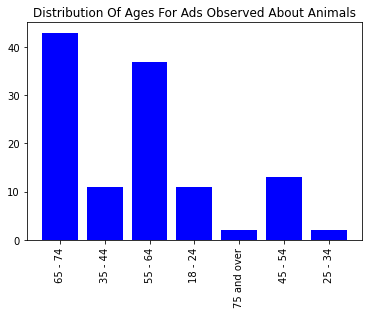

In [6]:

'''
    Calculate how ages vary for viewership of ads relating to pets
'''

distribution_of_ages = [x["age"] for x in all_observation_observer_identities]
available_ages = list(set(distribution_of_ages))
distribution_of_ages_encoded = [available_ages.index(y) for y in distribution_of_ages]

fig = plt.figure()
ax = fig.add_subplot(111)
xticks = list(range(len(available_ages)))
plt.bar(xticks, [distribution_of_ages_encoded.count(x) for x in xticks], color="blue")
ax.set_xticks(xticks)
ax.set_xticklabels(available_ages, rotation=90)
plt.title("Distribution Of Ages For Ads Observed About Animals")
plt.show()


In [9]:

'''
    Retrieve the image URLs that correspond to the images of the platform items
'''

retrieve_media_payload = dashboard_API_request({
    "action" : "retrieve_media",
        "data" : {
            "media" : library_of_image_urls[:10],
            "session_token" : session_token
        }
    })
image_urls = list(retrieve_media_payload["presigned_urls"].values())

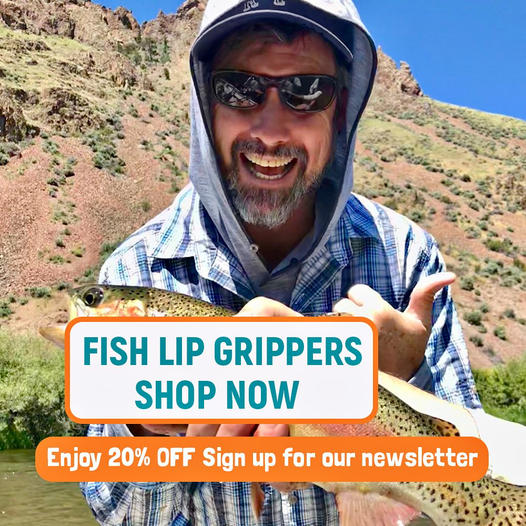

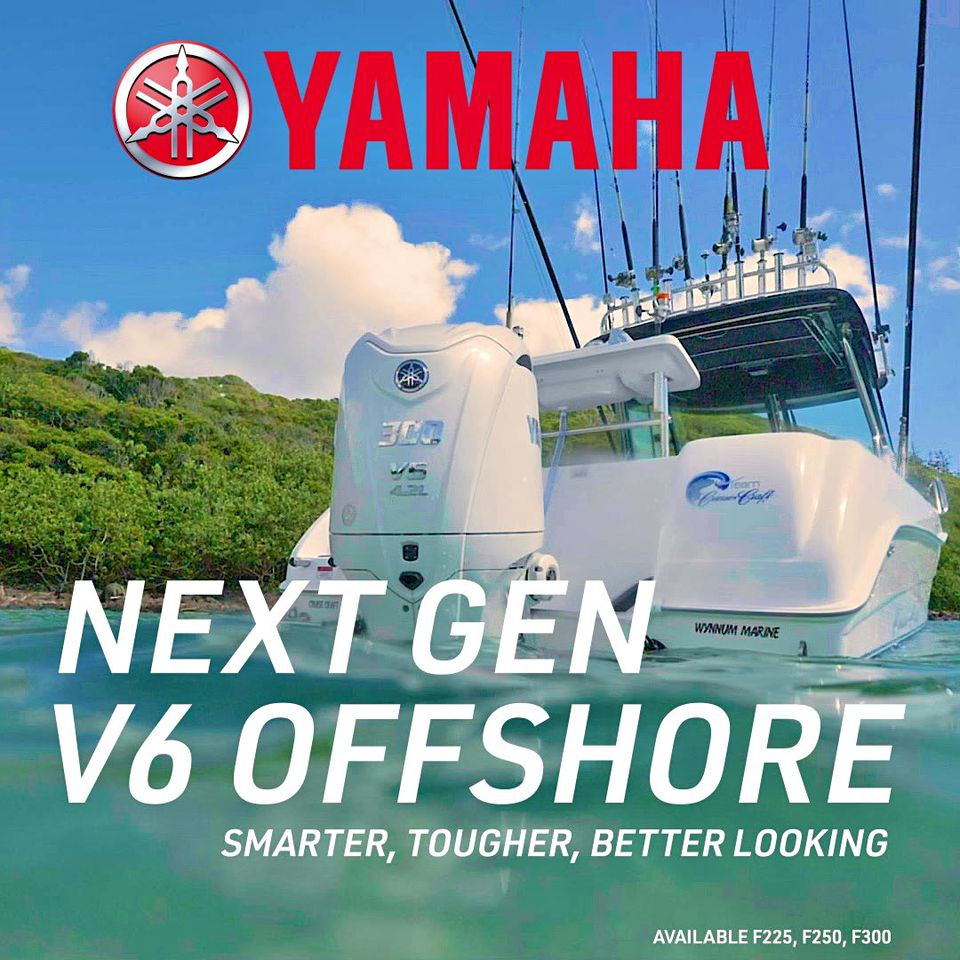

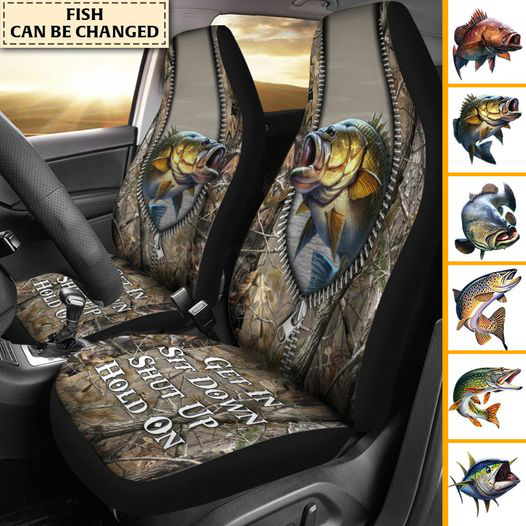

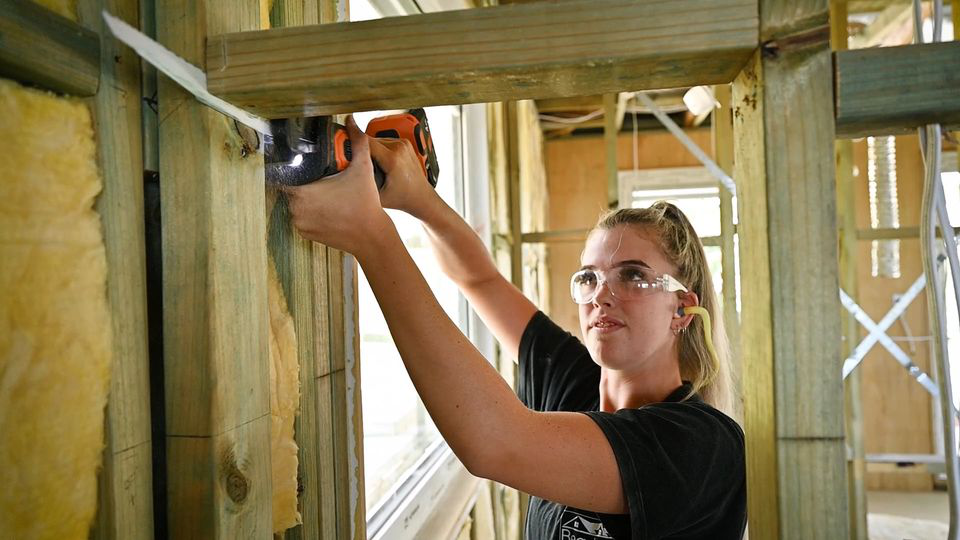

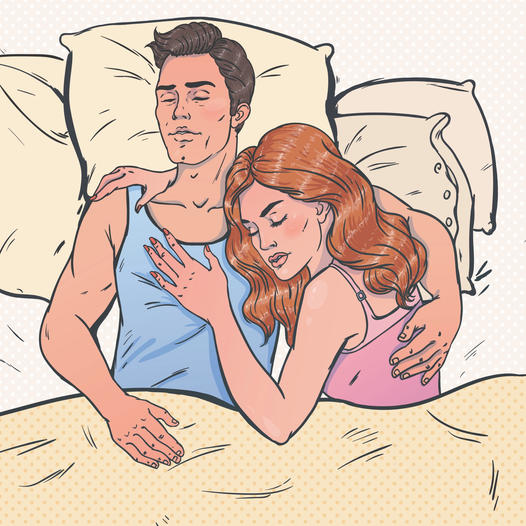

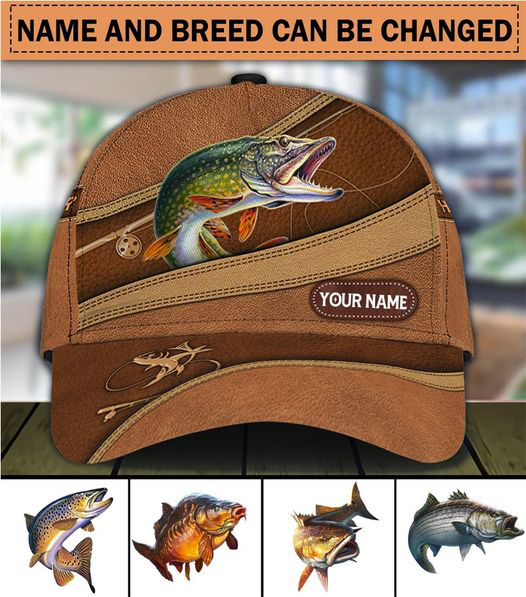

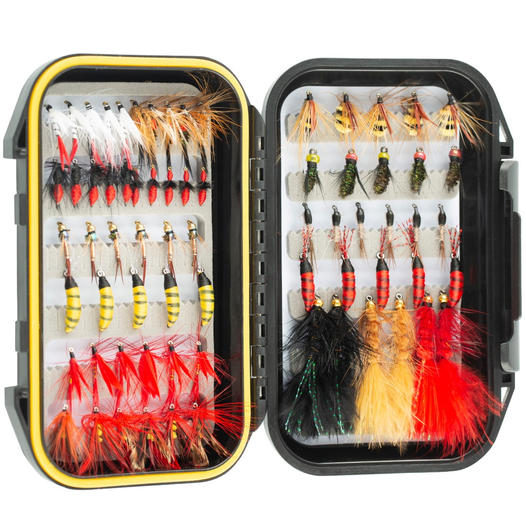

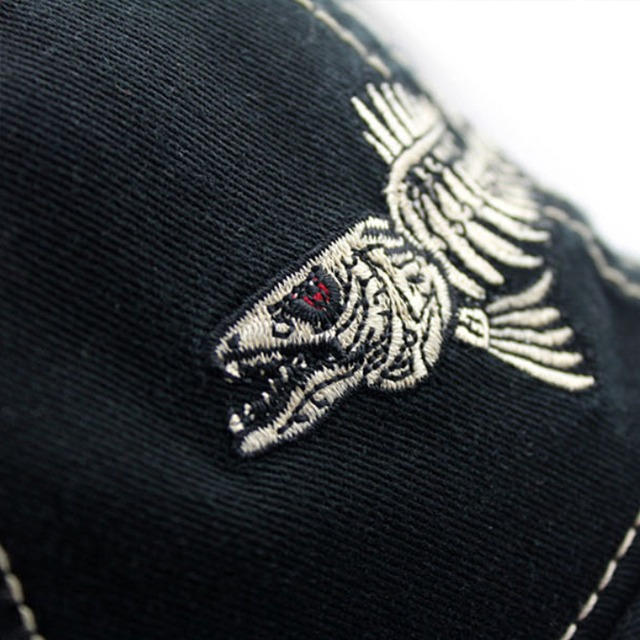

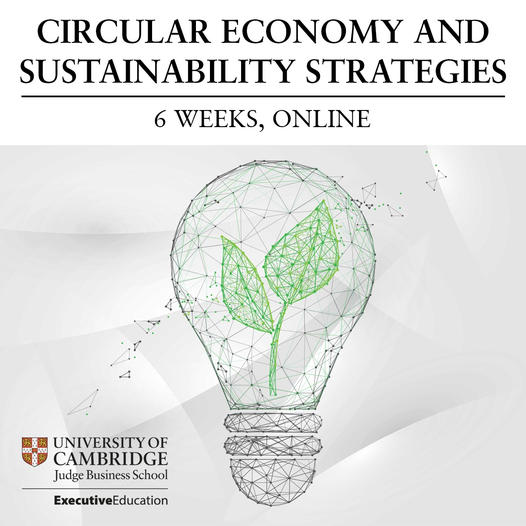

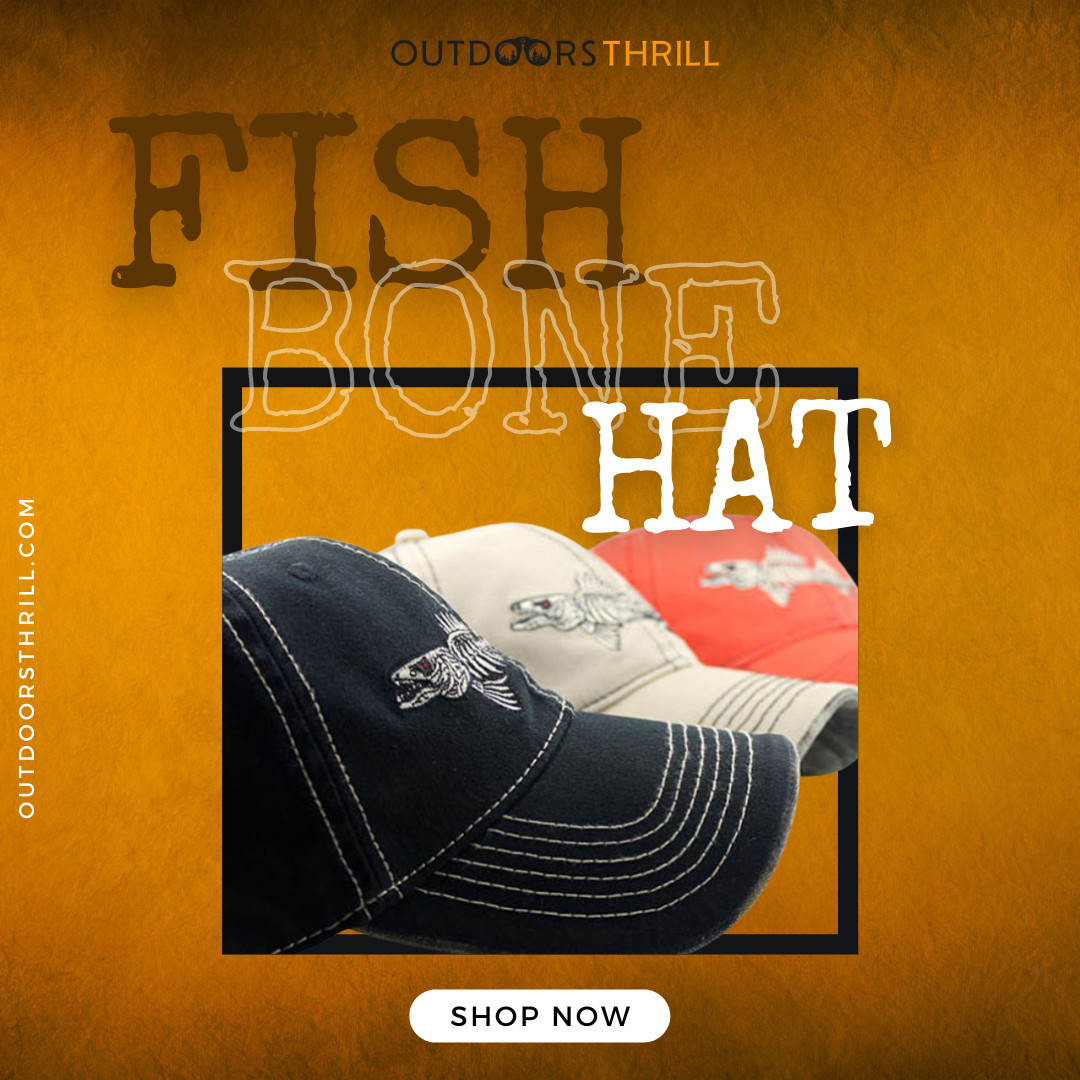

In [10]:

'''
    Display the images
'''

for image_url in image_urls:
    image = PIL.Image.open(io.BytesIO(requests.get(image_url).content))
    display(image)